### From counting to embeddings:

Previously our solution to the problem of predicting the next token / character was to initially build a probability distribution over the next token `P(ch2|ch1)` by counting the frequencies of occurence from the data. We built a 27 x 27 table where each cell represented `P(ch2|ch1)` for all possible character pairs. We then could sample from this model to generate new names. 

We then tried to use a simple one layer NN to learn these probabilities instead of explcitly counting them from the data. We extracted input and output dataset from our data and used gradient descent to optimize the weights of the model. The weights would then be transformed by some mathematical operations to represent probabilties we could compute loss for and also sample from after we train the model. 

The problem with the frequency table approach is that it can't scale. If we try to predict the next character given 1 previous character (called context of 1), we want a 27 x 27 table. Suppose rows represent the previous character, think what the size of the row needs to be if we want to take 2 characters / tokens as context, or 3 or more ..:
- context of 1: 27 rows
- context of 2: 27 x 27 rows (possible combinations of 2 tokens)
- context of 3: 27 x 27 x 27
- and so on

We'll find the size of the table grows "exponentially" with the size of the context. 

This won't work very well. This is why we needed the neural network approach. It's more flexible and scales better.

More context, joint probability and dimensionality;

When taking 1 token as context, we're trying to learn `P(ch2 | ch1)`. We did it via counting: 

$$P(\text{{ch2}}|\text{{ch1}}) = \frac{{\text{{Count}}(\text{{ch2, ch1}})}}{{\text{{Count}}(\text{{ch1, ch1}}) + \text{{Count}}(\text{{ch2, ch1}}) + \ldots + \text{{Count}}(\text{{ch26, ch1}})}}$$

ie:

$$P(\text{ch2}|\text{ch1}) = \frac{\text{Count}(\text{ch2, ch1})}{\sum_{i=1}^{26} \text{Count}(\text{chi, ch1})}$$


If we take 2 as context, we'll be learning `(P ch3 | ch1, ch2)`


$$P(\text{ch3} | \text{ch1}, \text{ch2}) = \frac{\text{Count}(\text{ch1, ch2, ch3})}{\text{Count}(\text{ch1, ch2, a}) + \text{Count}(\text{ch1, ch2, b}) + \ldots + \text{Count}(\text{ch1, ch2, z})}$$

In this expanded version:

- $\text{Count}(\text{ch1, ch2, ch3})$ represents the frequency of the sequence $\text{ch1, ch2}$ immediately followed by $\text{ch3}$.

- The denominator is the sum of counts for the sequence $\text{ch1, ch2}$ followed by each possible character in the English alphabet (from 'a' to 'z'). This sum gives the total number of times the sequence $\text{ch1, ch2}$ is followed by any character, serving as the normalization factor to convert raw counts into a probability.

Using the neural network, we try to learn probability model. The core idea is that the likelihood of any given token sequence in a language can be broken down into the product of conditional probabilities. Each token's probability depends on the sequence of tokens that precede it.

Consider a sequence of tokens/characters from 1 to $T$. The probability of this entire sequence is the product of the conditional probabilities of each token/character given all the previous tokens/characters. 

$$\hat{P}(t_{1}^{T}) = \hat{P}(t_1) \times \hat{P}(t_2 | t_1) \times \hat{P}(t_3 | t_1, t_2) \times \ldots \times \hat{P}(t_T | t_{1}^{T-1})$$

=

$$\hat{P}(t_{1}^{T}) = \prod_{t=1}^{T} \hat{P}(t_t | t_{1}^{t-1})$$


**In a nutshell, the n-gram models (bigram, trigram, etc) construct tables of conditional probabilities for the next character.**

The question now is, how do we provide more context to the NN. We also want to make the network itself bigger (more layers).

In building our 1 layer NN, we stumbled upon the idea of the embedding being equivalent to lookup table. We first turned tokens to integers. We then did one-not-encoding of integers in order to be able to provide them as input to the NN. The NN was one layer of neurons that do dot product of their inputs with synpases / weights. We saw how doing matrix multiplication of one-hot-encoded vector with a matrix of weights is equivalent to pulling out / indexing into the matrix to pluck out the row vector of weights that represented the probability distribution for any character X over its next possible 27 characters.

Now, we'll think of embedding in a different sense as a different way of encoding inputs (characters / tokens) provided to the neural network.

In the 1-layer approach, we used one-hot encoding (where each token is represented by a vector of the size of the vocabulary with all zeros except for a single one at the index representing the token). This is a sparse representation and could be very high dimensional (think of not a character-level language model of 26 characters but a text vocabulary of size 100,000 that could generate 10,000 tokens - this is a 10,000 vector input to your network).

Instead, we'll use token embeddings. The idea is to represent each token not as 1 in a one-hot-encoded vector space of vocabulary but we'll think of each token / word as having some hidden characteristics / features (if we're thinking of objects in the real world, this is the difference between representing each object as 1 in a one-hot-encoded table of ALL objects inte world but instead thinking of its characteristics such as size, shape, color, etc and representing each object as a vector of initially random numbers $[0.3, 0.5, .. ]$ that represent measurements over these characteristics / features). Embeddings as such compactly encode tokens in a much smaller dimensional space. 

The innovation here becomes that we allow the neural network not only to learn the sequence of tokens, but also learn the embeddings themselves. The distributional hypothesis (the foundational idea behind word embeddings), posits that words that appear in similar contexts tend to have similar meanings. By training models on large corpora of text, embeddings inherently learn these patterns, as the model's performance improves when similar words have similar embeddings.

Another useful gain is the process of learning embeddings effectively acts as a form of dimensionality reduction, where the high-dimensional space of the vocabulary is compressed into a lower-dimensional, dense vector space. This compression forces the model to encode as much information as possible about each word into a limited number of dimensions, leading to the emergence of semantically and syntactically meaningful patterns.

The goal is then to simultaneously learn the word feature vectors and the parameters of the joint probability function.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F 

### Embeddings:

We'll build our model following the [Bengio et al](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf) paper. We'll build it for our character level language model. We'll take 3 characters as input. We'll embed these in an intially 2D embedding matrix. We'll have 1 hidden layer and final output layer.

In [6]:
words = open('names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [16]:
vocab = sorted(list(set(''.join(words))))
vocab[:5]

['a', 'b', 'c', 'd', 'e']

In [20]:
# encoding and decoding
stoi = {s:i+1 for i,s in enumerate(vocab)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [27]:
sz = 3
context = sz * ['.']
for w in words[:1]:
    w = '.' + w + '.'
    for ch in w:
        print(context, ch)
        context = context[1:] + [ch]

['.', '.', '.'] .
['.', '.', '.'] e
['.', '.', 'e'] m
['.', 'e', 'm'] m
['e', 'm', 'm'] a
['m', 'm', 'a'] .


In [54]:
xs, ys = [], []
context_size = 3
n = 5 #number of words to consider in dataset 

context = context_size * [0]
for w in words[:n]:
    for ch in w + '.':
        ix = stoi[ch]
        context = context[1:] + [ix]
        xs.append(context)
        ys.append(ix)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
xs.shape, ys.shape

(torch.Size([32, 3]), torch.Size([32]))

In [62]:
#embedding matrix
emb_size = 2
C = torch.randn(27, emb_size)
C.shape

torch.Size([27, 2])

In [63]:
# embed the dataset - extract embeddings for input indices
emb = C[xs] # how to simultaneously embed multiple inputs
emb.shape

torch.Size([32, 3, 2])

In [67]:
# adjust dimensions to make it a 2D matrix
emb.view(-1, context_size * emb_size).shape

torch.Size([32, 6])

In [77]:
hidden_size = 100
W1 = torch.randn(context_size * emb_size, hidden_size)
b1 = torch.randn(hidden_size)
W2 = torch.randn(hidden_size, 27)
b2 = torch.randn(27)
W1.shape, W2.shape

(torch.Size([6, 100]), torch.Size([100, 27]))

In [80]:
# forward pass
h = torch.tanh(emb.view(-1, context_size * emb_size) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [81]:
logits = h @ out + b2
logits.shape

torch.Size([32, 27])

In [82]:
# calculate loss as before with 1 layer model
counts = logits.exp()
probs = counts / counts.sum(dim=1, keepdim=True)
probs.shape

torch.Size([32, 27])

In [84]:
probs[0]

tensor([1.1881e-02, 6.0892e-04, 1.5999e-04, 8.8785e-05, 1.2108e-07, 3.4456e-11,
        2.8165e-03, 9.2810e-07, 9.0839e-01, 1.0322e-07, 2.1488e-05, 1.1048e-04,
        2.7073e-02, 2.6118e-06, 4.1120e-09, 4.7512e-08, 2.1020e-09, 5.2692e-06,
        1.0211e-05, 4.3473e-02, 2.5301e-06, 1.1633e-07, 9.5978e-08, 1.0293e-04,
        1.0196e-07, 5.1491e-03, 9.7325e-05])

In [83]:
probs[0].sum()

tensor(1.0000)

In [89]:
# pluck out the probabilities for correct labels to compute loss on them
probs[torch.arange(32), ys].shape

torch.Size([32])

In [91]:
# compute average negative log likelihood 
loss = -probs[torch.arange(32), ys].log().mean()
loss

tensor(17.0360)

### Splitting to train / val / test:

In [101]:
context_size = 3

def build_dataset(words):
    xs, ys = [], []
    for w in words:
        context = context_size * [0]
        for ch in w + '.':
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:] + [ix]

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print(xs.shape, ys.shape)
    return xs, ys

In [102]:
xs, ys = build_dataset(words[:5])

torch.Size([32, 3]) torch.Size([32])


In [106]:
# How we'll split into train / dev / test sets: 
# -> random shuffle words then slice
import random
random.seed(42)

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
xtrn, ytrn = build_dataset(words[ :n1])
xdev, ydev = build_dataset(words[n1:n2])
xte, yte = build_dataset(words[n2: ])

torch.Size([182421, 3]) torch.Size([182421])
torch.Size([22832, 3]) torch.Size([22832])
torch.Size([22893, 3]) torch.Size([22893])


In [109]:
W1.shape, W2.shape

(torch.Size([6, 100]), torch.Size([100, 27]))

In [126]:
# params and hyperparams
lr = 0.01
emb_size = 2
hidden_size = 100

C = torch.randn(27, emb_size)
W1 = torch.randn(context_size * emb_size, hidden_size)
b1 = torch.randn(hidden_size)
W2 = torch.randn(hidden_size, 27)
b2 = torch.randn(27)
W1.shape, W2.shape

(torch.Size([6, 100]), torch.Size([100, 27]))

In [127]:
parameters = [C, W1, W2, b1, b2]
for p in parameters:
    p.requires_grad = True

In [128]:
sum(p.nelement() for p in parameters) # number of parameters in total

3481

In [129]:
# the training loop
lossi = []
stepi = []

for i in range(100):
    #forward pass
    xenc = C[xtrn]
    h = torch.tanh(xenc.view(-1, context_size * emb_size) @ W1 + b1)
    logits = h @ W2 + b2
    # compute loss
    loss = F.cross_entropy(logits, ytrn)
    # zero grad
    for p in parameters:
        p.grad = None
    # backprop
    loss.backward()
    # update weights
    for p in parameters:
        p.data += -lr * p.grad

    if i % 1000 == 0:
        print(loss.item())

    # track statistics
    lossi.append(loss.item())
    stepi.append(i)

16.976476669311523


In [142]:
# plt.plot(stepi, lossi);

In [156]:
# params and hyperparams
lr = 0.01
emb_size = 2
hidden_size = 100
batch_size = 32

C = torch.randn(27, emb_size)
W1 = torch.randn(context_size * emb_size, hidden_size)
b1 = torch.randn(hidden_size)
W2 = torch.randn(hidden_size, 27)
b2 = torch.randn(27)
print(W1.shape, W2.shape)

parameters = [C, W1, W2, b1, b2]
for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters) # number of parameters in total

# keep stats here to avoid re-initializing every time we loop
lossi = []
stepi = []

torch.Size([6, 100]) torch.Size([100, 27])


In [160]:
# let's make it faster by training on minibatches
for i in range(50000):
    # create mini-batches
    ixs = torch.randint(0, xtrn.size(0), (batch_size, )) # random indices / samples from training set
    xs = xtrn[ixs]
    ys = ytrn[ixs]
    
    xenc = C[xs]
    h = torch.tanh(xenc.view(-1, context_size * emb_size) @ W1 + b1)
    logits = h @ W2 + b2

    # loss
    loss = F.cross_entropy(logits, ys)
    # zero grad
    for p in parameters:
        p.grad = None

    #backprop
    loss.backward()

    lr = 0.1 if i < 10000 else 0.01
    # weight update
    for p in parameters:
        p.data += -lr * p.grad

    lossi.append(loss.item())
    stepi.append(i)


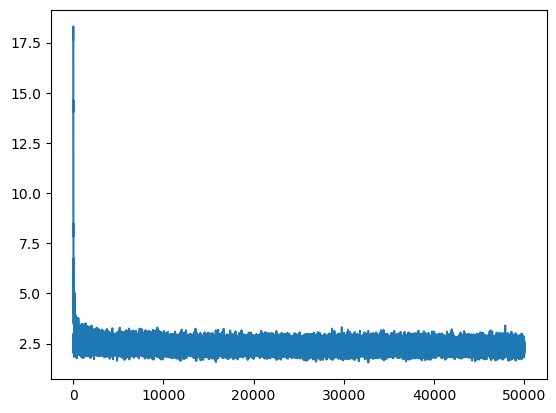

In [161]:
plt.plot(stepi, lossi);

In [162]:
loss.item()

2.1321563720703125

In [167]:
# evaluate on dev set
# to eval-> full pass through network and compute final loss
def eval_loss(x,y):
    with torch.no_grad():         
        xenc = C[x]
        h = torch.tanh(xenc.view(-1, context_size * emb_size) @ W1 + b1)
        logits = h @ W2 + b2
        loss = F.cross_entropy(logits, y)
        print(loss.item())

In [168]:
eval_loss(xdev, ydev)

2.318882942199707


In [192]:
# sampling from this distribution: we want to get probabilities to sampe from.
# these will be derived from the logits in the final layer
# as before, we sample letter after another
# we start at . . .
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(10):
    out = []
    context = [0] * context_size
    while True:
        xenc = C[context]
        h = torch.tanh(xenc.view(-1, context_size * emb_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

mria.
kayan.
seel.
ndynyal.
rethastendrlee.
aderedielin.
shi.
jen.
edellestanar.
kayzioh.
